In [ ]:
#| default_exp ipfshttpapi

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

# IPFS HTTP API

> IPFS HTTP API based Python functions to interact with IPFS

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
#| hide
from typing import Union, List

import requests
import json
from fastcore.all import *
import pandas as pd
import dag_cbor
from requests.exceptions import HTTPError
import time

from ipfspy.utils import parse_error_message, parse_response, IPFSGateway, GATEWAY_MAP

from ipfshttpclient.multipart import stream_files, stream_directory

In [ ]:
#| export
class IPFSApi():
    def __init__(self,
        gateway_type='local', # Gateway to use - `public`, `infura`, `local` 
        timeout=10, # 
        **kwargs
    ):
        
        self.gateway = None
        self._gateways = None

        self.change_gateway_type = gateway_type
        self.timeout = timeout
        self.full_structure = None
    
    @property
    def change_gateway_type(self):
        return self.gateway_type

    @change_gateway_type.setter    
    def change_gateway_type(self, 
        value, 
        ):
        self.gateway_type = value
        self._gateways = [IPFSGateway(g) for g in GATEWAY_MAP[self.gateway_type]] 
        print(f"Changed to {self.gateway_type} node")
    
    def _find_gateway(self):
        backoff_list = []
        for gw in self._gateways:
            state, wait_time = gw.get_state()
            if state == "online":
                return gw, 0
            if state == "backoff":
                backoff_list.append((wait_time, gw))
        if len(backoff_list) > 0:
            return sorted(backoff_list)[0][::-1]
        else:
            raise RuntimeError("no working gateways could be found")

    def _run_on_any_gateway(self, f):
        timeout = time.monotonic() + self.timeout
        while time.monotonic() <= timeout:
            gw, wait_time = self._find_gateway()
            if wait_time > 0:
                time.sleep(wait_time)
            res = f(gw)
            if res is not None:
                break
        return res
        
    def _gw_get(self, path):
        return self._run_on_any_gateway(lambda gw: gw.get(path))

    def _gw_head(self, path, headers=None):
        return self._run_on_any_gateway(lambda gw: gw.head(path, headers))

    def _gw_apipost(self, call, **kwargs): 
        return self._run_on_any_gateway(lambda gw: gw.apipost(call, **kwargs))
    
    def add_items(self,
        filepath:Union[str, List[str]], # Path to the file/directory to be added to IPFS
        directory:bool=False, # Is filepath a directory
        wrap_with_directory:bool=False, # True if path is a directory
        chunker:str='size-262144', # Chunking algorithm, size-[bytes], rabin-[min]-[avg]-[max] or buzhash
        pin:bool=True, # Pin this object when adding
        hash_:str='sha2-256', # Hash function to use. Implies CIDv1 if not sha2-256
        progress:str='true', # Stream progress data
        silent:str='false', # Write no output
        cid_version:int=0, # CID version
        **kwargs,
        ):
        "add file/directory to ipfs"

        params = {}
        params['wrap-with-directory'] = 'true' if wrap_with_directory else 'false'
        params['chunker'] = chunker
        params['pin'] = 'true' if pin else 'false'
        params['hash'] = hash_
        params['progress'] = progress
        params['silent'] = silent
        params['cid-version'] = cid_version
        params.update(kwargs)
        
        chunk_size = int(chunker.split('-')[1])

        if not directory:
            data, headers = stream_files(filepath, chunk_size=chunk_size)

        else:
            data, headers = stream_directory(filepath, chunk_size=chunk_size, recursive=True)

        response = self._gw_apipost('add', 
                                    params=params, 
                                    data=data,
                                    headers=headers)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def ls_items(self,
        cid:str, # The path to the IPFS object(s) to list links from
        resolve_type:bool=True, # Resolve linked objects to find out their types
        size:bool=True, # Resolve linked objects to find out their file size
        **kwargs,
    ):
        'List directory contents for Unix filesystem objects'

        params = {}
        params['arg'] = cid
        params['resolve-type'] = 'true' if resolve_type else 'false'
        params['size'] = 'true' if size else 'false'
        params.update(kwargs)

        response = self._gw_apipost('ls', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def get_items(self,
        cid:str, # The path to the IPFS object(s) to be outputted
        output:str='', # The path where the output should be stored
        **kwargs
    ):
        'Download IPFS objects'

        params = {}
        params['arg'] = cid
        params['output'] = output
        params.update(kwargs)

        response = self._gw_apipost('get', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def cat_items(self,
        cid:str, # The path to the IPFS object(s) to be output
        **kwargs
    ):
        'Show IPFS object data'

        params = {}
        params['arg'] = cid
        params.update(kwargs)

        response = self._gw_apipost('cat', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
    
    def dag_export(self,
        cid:str, #The path to the IPFS DAG node
        **kwargs,
    ):
        'Streams the selected DAG as a .car stream on stdout.'

        params = {}
        params['arg'] = cid
        params.update(kwargs)

        response = self._gw_apipost('dag/export', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def dag_get(self,
        cid:str, #The path to the IPFS DAG node
        output_codec:str='dag-json',
    ):
        'Get a DAG node from IPFS.'

        params = {}
        params['arg'] = cid
        params['output-codec'] = output_codec

        response = self._gw_apipost('dag/get', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def dag_stat(self,
        cid:str, #The path to the IPFS DAG node 
        **kwargs, 
    ):
        'Gets stats for a DAG.'

        params = {}
        params['arg'] = cid
        params.update(kwargs)

        response = self._gw_apipost('dag/stat', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
    
    def pin_add(self,
        cid:str, # Path to IPFS object(s) to be pinned
        recursive:str='true', # Recursively pin the object linked to by the specified object(s)
    ):
        'Pin objects to local storage.'

        params = {}
        params['arg'] = cid
        params['recursive'] = recursive

        response = self._gw_apipost('pin/add', params=params)
        
        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def pin_ls(self,
        type_:str='all', # The type of pinned keys to list. Can be "direct", "indirect", "recursive", or "all"
        **kwargs,
    ):
        'List objects pinned to local storage.'    

        params = {}
        params['type'] = type_
        params.update(kwargs)

        response = self._gw_apipost('pin/ls', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def pin_rm(self,
        cid:str, # Path to object(s) to be unpinned
        recursive:str='true', #  Recursively unpin the object linked to by the specified object(s)
        **kwargs,
    ):
        'List objects pinned to local storage.'    

        params = {}
        params['arg'] = cid
        params['recursive'] = recursive
        params.update(kwargs)

        response = self._gw_apipost('pin/rm', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def rspin_add(self,
        service_name:str, # Name of the remote pinning service to use
        service_edpt:str, # Service endpoint
        service_key:str, # Service key
    ):
        'Pin object to remote pinning service.'

        params = {}
        params['arg'] = [service_name, service_edpt, service_key]

        response = self._gw_apipost('pin/remote/service/add', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def rspin_ls(self,
        **kwargs
    ):
        'List remote pinning services.'

        params = {}
        params.update(kwargs)

        response = self._gw_apipost('pin/remote/service/ls', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))


    def rspin_rm(self,
        service_name:str, # Name of pinning service to remove
    ):
        'Remove remote pinning service.'

        params = {}
        params['arg'] = service_name

        response = self._gw_apipost('pin/remote/service/rm', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
    
    def rpin_add(self,
        cid:str, #  Path to IPFS object(s) to be pinned
        service:str, # Name of the remote pinning service to use
        background:str='false', # Add to the queue on the remote service and return immediately (does not wait for pinned status)
        **kwargs,
    ):
        'Pin object to remote pinning service.'

        params = {}
        params['arg'] = cid
        params['service'] = service
        params['background'] = background
        params.update(kwargs)

        response = self._gw_apipost('pin/remote/add', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))


    def rpin_ls(self,
        service:str, # Name of the remote pinning service to use
        **kwargs, 
    ):
        'List objects pinned to remote pinning service.'

        params = {}
        params['service'] = service
        params.update(kwargs)

        response = self._gw_apipost('pin/remote/ls', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def rpin_rm(self,
        service:str, # Name of the remote pinning service to use
        **kwargs, 
    ):
        'Remove pins from remote pinning service.'    

        params = {}
        params['service'] = service
        params.update(kwargs)

        response = self._gw_apipost('pin/remote/rm', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
            
    def block_get(self,
        cid:str, # The base58 multihash of an existing block to get

    ):
        'Get a raw IPFS block.'

        params = {}
        params['arg'] = cid

        response = self._gw_apipost('block/get', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def block_put(self,
        filepath:str, # Path to file
        mhtype:str='sha2-256', # multihash hash function.
        mhlen:int=-1, # Multihash hash length
        pin:str=False, #  pin added blocks recursively
        **kwargs,
    ):
        'Store input as an IPFS block.'

        params = {}
        params['mhtype'] = mhtype
        params['mhlen'] = mhlen
        params['pin'] = 'true' if pin else 'false'
        params.update(kwargs)

        response = self._gw_apipost('block/put', params=params, files={'files':open(filepath, 'rb')})

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
            
    def block_rm(self,
        cid:str, # Bash58 encoded multihash of block(s) to remove
        force:str='false', # Ignore nonexistent blocks.
        quiet:str='false', # Write minimal output.
    ):
        'Remove IPFS block(s).'

        params = {}
        params['arg'] = cid
        params['force'] = force
        params['quiet'] = quiet

        response = self._gw_apipost('block/rm', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def block_stat(self,
        cid:str, # Bash58 encoded multihash of block(s) to remove

    ):
        'Print information of a raw IPFS block.'

        params = {}
        params['arg'] = cid

        response = self._gw_apipost('block/stat', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
            
    def mfs_chcid(self,
        path:str='/', # Path to change
        cid_version:int=0, # Cid version to use
        **kwargs,
    ):
        'Change the CID version or hash function of the root node of a given path.'

        params = {}
        params['arg'] = path
        params['cid-version'] = cid_version
        params.update(kwargs)

        response = self._gw_apipost("files/chcid", params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_cp(self,
        source_path:str, # Source IPFS or MFS path to copy
        dest_path:str, # Destination within MFS
        **kwargs
    ):
        'Add references to IPFS files and directories in MFS (or copy within MFS).'

        params = {}
        params['arg'] = [source_path, dest_path]
        params.update(kwargs)

        response = self._gw_apipost('files/cp', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_flush(self,
        path:str='/', # Path to flush
    ):
        "Flush a given path's data to disk"

        params['arg'] = path

        response = self._gw_apipost('files/flush',params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_ls(self, 
        path:str='/', # Path to show listing for 
        **kwargs
    ):
        "List directories in the local mutable namespace."

        params = {}
        params['arg'] = path
        params.update(kwargs)

        response = self._gw_apipost('files/ls', params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_mkdir(self,
        path:str, # Path to dir to make
        **kwargs,
    ):
        "Make directories."

        params = {}
        params['arg'] = path
        params.update(kwargs)

        response = self._gw_apipost("files/mkdir", params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_mv(self,
        source_path:str, # Source file to move
        dest_path:str,  # Destination path for file to be moved to
    ):
        "Move files."

        params = {}
        params['arg'] = [source_path, dest_path]

        response = self._gw_apipost("files/mv", params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_read(self,
        path, # Path to file to be read
        **kwargs,
    ):
        "Read a file in a given MFS."

        params = {}
        params['arg'] = path
        params.update(kwargs)

        response = self._gw_apipost("files/read",params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))
            
    def mfs_rm(self,
        path, # File to remove
        **kwargs,
    ):
        "Read a file in a given MFS."

        params = {}
        params['arg'] = path
        params.update(kwargs)

        response = self._gw_apipost("files/rm", params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_stat(self,
        path, # Path to node to stat
        **kwargs,
    ):
        "Display file status."    

        params = {}
        params['arg'] = path
        params.update(kwargs)

        response = self._gw_apipost("files/stat", params=params)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

    def mfs_write(self,
        path, # Path to write to
        filepath, # File to add
        create=True, # Create the file if it does not exist
        **kwargs,
    ):
        "Display file status."    

        files = {
            'file': open(filepath, 'rb')
        }

        params = {}
        params['arg'] = path
        params['create'] = 'true' if create else 'false'
        params.update(kwargs)

        response = self._gw_apipost("files/write", params=params, files=files)

        if response.status_code == 200:
            return response, parse_response(response)

        else:
            raise HTTPError (parse_error_message(response))

## Choosing your gateway

By default, the `IPFSApi` uses the `local` node.

In [ ]:
#| ignoretest
api = IPFSApi()

Changed to local node


To change to `infura` or `public` use the `change_gateway_type` method

In [ ]:
#| ignoretest
api.change_gateway_type = 'infura'

Changed to infura node


In [ ]:
#| ignoretest
api.change_gateway_type = 'public'

Changed to public node


In [ ]:
#| ignoretest
api.change_gateway_type = 'local'

Changed to local node


## UnixFS

### add_items

- only available on `local` and `infura` nodes

In [ ]:
show_doc(IPFSApi.add_items)

<h4 id="IPFSApi.add_items" class="doc_header"><code>IPFSApi.add_items</code><a href="__main__.py#L61" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.add_items</code>(**`filepath`**:`Union`\[`str`, `typing.List[str]`\], **`directory`**:`bool`=*`False`*, **`wrap_with_directory`**:`bool`=*`False`*, **`chunker`**:`str`=*`'size-262144'`*, **`pin`**:`bool`=*`True`*, **`hash_`**:`str`=*`'sha2-256'`*, **`progress`**:`str`=*`'true'`*, **`silent`**:`str`=*`'false'`*, **`cid_version`**:`int`=*`0`*, **\*\*`kwargs`**)

add file/directory to ipfs

||Type|Default|Details|
|---|---|---|---|
|**`filepath`**|`typing.Union[str, typing.List[str]]`||Path to the file/directory to be added to IPFS|
|**`directory`**|`bool`|`False`|Is filepath a directory|
|**`wrap_with_directory`**|`bool`|`False`|True if path is a directory|
|**`chunker`**|`str`|`size-262144`|Chunking algorithm, size-[bytes], rabin-[min]-[avg]-[max] or buzhash|
|**`pin`**|`bool`|`True`|Pin this object when adding|
|**`hash_`**|`str`|`sha2-256`|Hash function to use. Implies CIDv1 if not sha2-256|
|**`progress`**|`str`|`true`|Stream progress data|
|**`silent`**|`str`|`false`|Write no output|
|**`cid_version`**|`int`|`0`|CID version|
|**`kwargs`**|||*No Content*|


#### Using local IPFS Node

> Important: This requires a local IPFS Node to be run. Set up your local node using info [here](https://ipfs.io/#install). 


> Note: Full list of available `params` on `add` function can be found [here](https://docs.ipfs.io/reference/http/api/#api-v0-add)


Upload a file

In [ ]:
#| ignoretest
response, jsonobject = api.add_items(filepath="../README.md"); jsonobject

[{'Name': 'README.md', 'Bytes': 1179},
 {'Name': 'README.md',
  'Hash': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
  'Size': '1190'}]

Upload multiple files

In [ ]:
#| ignoretest
response, jsonobject = api.add_items(filepath=["../README.md", 'output/test.txt']); jsonobject

[{'Name': 'README.md', 'Bytes': 1179},
 {'Name': 'README.md',
  'Hash': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
  'Size': '1190'},
 {'Name': 'test.txt', 'Bytes': 24},
 {'Name': 'test.txt',
  'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
  'Size': '32'}]

You can view the added file on [ipfs.io](https://ipfs.io/ipfs/QmfQ5hFqZ2DFUwTfnaPEuVXXSXsq552AXMvjrQtbkQKWLZ)

To view any CID on ipfs.io `https://ipfs.io/ipfs/CID`

Upload multiple file wrapped in a directory

In [ ]:
#| ignoretest
response, jsonobject = api.add_items(filepath=["../README.md", 'output/test.txt'], wrap_with_directory='true'); jsonobject

[{'Name': 'README.md', 'Bytes': 1179},
 {'Name': 'README.md',
  'Hash': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
  'Size': '1190'},
 {'Name': 'test.txt', 'Bytes': 24},
 {'Name': 'test.txt',
  'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
  'Size': '32'},
 {'Name': '',
  'Hash': 'Qmbu99JbYDXGCf9bprV355A5hLLE6ogHe5FM4BVAZmqU9i',
  'Size': '1328'}]

Upload a directory

In [ ]:
#| ignoretest
response, jsonobject = api.add_items(filepath='output', directory=True); jsonobject[-4:]

[{'Name': 'output/fol1/fol2/test3.txt',
  'Hash': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9',
  'Size': '40'},
 {'Name': 'output/fol1/fol2',
  'Hash': 'QmRGeFLyf3ZANQFVdVvo8RzSrBcs7BGGqN6wn764xmwopA',
  'Size': '3975794'},
 {'Name': 'output/fol1',
  'Hash': 'QmdK9agin1q8YdTaUQ6v81pWBu8TencfijyPGVZ5epFxvR',
  'Size': '7951637'},
 {'Name': 'output',
  'Hash': 'QmWJvSt7QGY2yhr9mrfAm76vRvxXA5ygB4zd2SmfD43vtX',
  'Size': '11927480'}]

#### Using infura.io gateway

This works without a local IPFS node running

In [ ]:
#| ignoretest
api.change_gateway_type = 'infura'

Changed to infura node


In [ ]:
#| ignoretest
response, jsonobject = api.add_items("../README.md"); jsonobject

[{'Name': 'README.md', 'Bytes': 1179},
 {'Name': 'README.md',
  'Hash': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
  'Size': '1190'}]

In [ ]:
#| ignoretest
response, jsonobject = api.add_items(filepath='output', directory=True); jsonobject[-4:]

[{'Name': 'output/fol1/fol2/test3.txt',
  'Hash': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9',
  'Size': '40'},
 {'Name': 'output/fol1/fol2',
  'Hash': 'QmRGeFLyf3ZANQFVdVvo8RzSrBcs7BGGqN6wn764xmwopA',
  'Size': '3975794'},
 {'Name': 'output/fol1',
  'Hash': 'QmdK9agin1q8YdTaUQ6v81pWBu8TencfijyPGVZ5epFxvR',
  'Size': '7951637'},
 {'Name': 'output',
  'Hash': 'QmWJvSt7QGY2yhr9mrfAm76vRvxXA5ygB4zd2SmfD43vtX',
  'Size': '11927480'}]

You can view the added file on [infura.io](https://ipfs.infura.io/ipfs/QmfQ5hFqZ2DFUwTfnaPEuVXXSXsq552AXMvjrQtbkQKWLZ)

To view any CID on infura `https://ipfs.infura.io/ipfs/CID`

### ls_items

- only available on `local` and `public` nodes. `ls` not implemented on `infura`

In [ ]:
#| ignoretest
show_doc(IPFSApi.ls_items)

<h4 id="IPFSApi.ls_items" class="doc_header"><code>IPFSApi.ls_items</code><a href="__main__.py#L104" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.ls_items</code>(**`cid`**:`str`, **`resolve_type`**:`bool`=*`True`*, **`size`**:`bool`=*`True`*, **\*\*`kwargs`**)

List directory contents for Unix filesystem objects

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||The path to the IPFS object(s) to list links from|
|**`resolve_type`**|`bool`|`True`|Resolve linked objects to find out their types|
|**`size`**|`bool`|`True`|Resolve linked objects to find out their file size|
|**`kwargs`**|||*No Content*|


In [ ]:
#| ignoretest
api.change_gateway_type = 'local'

Changed to local node


In [ ]:
#| ignoretest
response, content = api.ls_items('QmeyTiqrD6oo4eQXbAt7hZn3ASzpcP3Kvb1rc9qznEowEw'); content

[{'Objects': [{'Hash': 'QmeyTiqrD6oo4eQXbAt7hZn3ASzpcP3Kvb1rc9qznEowEw',
    'Links': [{'Name': 'adult_data.csv',
      'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
      'Size': 3974475,
      'Type': 2,
      'Target': ''},
     {'Name': 'fol1',
      'Hash': 'QmUNLLsPACCz1vLxQVkXqqLX5R1X345qqfHbsf67hvA3Nn',
      'Size': 0,
      'Type': 1,
      'Target': ''},
     {'Name': 'test.txt',
      'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
      'Size': 24,
      'Type': 2,
      'Target': ''},
     {'Name': 'test2.txt',
      'Hash': 'QmWa7aPQWCkLAmV2pt1Wjj3uE7V3CG3KYMKBKsVAvWG649',
      'Size': 23,
      'Type': 2,
      'Target': ''},
     {'Name': 'test3.txt',
      'Hash': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9',
      'Size': 32,
      'Type': 2,
      'Target': ''}]}]}]

In [ ]:
#| ignoretest
api.change_gateway_type = 'public'

Changed to public node


In [ ]:
#| ignoretest
response, content = api.ls_items('QmeyTiqrD6oo4eQXbAt7hZn3ASzpcP3Kvb1rc9qznEowEw'); content

[{'Objects': [{'Hash': 'QmeyTiqrD6oo4eQXbAt7hZn3ASzpcP3Kvb1rc9qznEowEw',
    'Links': [{'Name': 'adult_data.csv',
      'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
      'Size': 3974475,
      'Type': 2,
      'Target': ''},
     {'Name': 'fol1',
      'Hash': 'QmUNLLsPACCz1vLxQVkXqqLX5R1X345qqfHbsf67hvA3Nn',
      'Size': 0,
      'Type': 1,
      'Target': ''},
     {'Name': 'test.txt',
      'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
      'Size': 24,
      'Type': 2,
      'Target': ''},
     {'Name': 'test2.txt',
      'Hash': 'QmWa7aPQWCkLAmV2pt1Wjj3uE7V3CG3KYMKBKsVAvWG649',
      'Size': 23,
      'Type': 2,
      'Target': ''},
     {'Name': 'test3.txt',
      'Hash': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9',
      'Size': 32,
      'Type': 2,
      'Target': ''}]}]}]

### cat_items

In [ ]:
#| ignoretest
show_doc(IPFSApi.cat_items)

<h4 id="IPFSApi.cat_items" class="doc_header"><code>IPFSApi.cat_items</code><a href="__main__.py#L146" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.cat_items</code>(**`cid`**:`str`, **\*\*`kwargs`**)

Show IPFS object data

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||The path to the IPFS object(s) to be output|
|**`kwargs`**|||*No Content*|


When given a file CID

In [ ]:
#| ignoretest
api.change_gateway_type = 'local'

Changed to local node


In [ ]:
#| ignoretest
response, content = api.cat_items(cid='QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B'); content

'# Welcome to Immerse by Algovera\r\n> A python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services\r\n\r\n\r\n## What is Immerse?\r\n\r\nImmerse is a python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services. It is designed by data scientists for data scientists to interact with the IPFS ecosystem without leaving the comfort of python and jupyter notebook.\r\n\r\nYou can learn more about IPFS [here](https://ipfs.io/#why)\r\n\r\nIPFS is built using the go-lang and javascript. With Immerse, you can interact with IPFS using the exposed [HTTP RPC API](https://docs.ipfs.io/reference/http/api/#getting-started). \r\n\r\nYou will need a local IPFS Node running to use the HTTP API (even when using Immerse). As an alternative, you can connect via the [Infura](https://infura.io/product/ipfs)\'s dedicated IPFS gateway. Immerse provide both ways to interact with IPFS.\r\n\r\n## Installing\r\n\r\nto do: instr

When given a directory CID (this will throw an error)

In [ ]:
#| ignoretest
response, content = api.cat_items(cid='QmeyTiqrD6oo4eQXbAt7hZn3ASzpcP3Kvb1rc9qznEowEw'); content

HTTPError: Response Status Code: 500; Error Message: this dag node is a directory

In [ ]:
#| ignoretest
api.change_gateway_type = 'public'

Changed to public node


In [ ]:
#| ignoretest
response, content = api.cat_items(cid='QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B'); content

'# Welcome to Immerse by Algovera\r\n> A python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services\r\n\r\n\r\n## What is Immerse?\r\n\r\nImmerse is a python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services. It is designed by data scientists for data scientists to interact with the IPFS ecosystem without leaving the comfort of python and jupyter notebook.\r\n\r\nYou can learn more about IPFS [here](https://ipfs.io/#why)\r\n\r\nIPFS is built using the go-lang and javascript. With Immerse, you can interact with IPFS using the exposed [HTTP RPC API](https://docs.ipfs.io/reference/http/api/#getting-started). \r\n\r\nYou will need a local IPFS Node running to use the HTTP API (even when using Immerse). As an alternative, you can connect via the [Infura](https://infura.io/product/ipfs)\'s dedicated IPFS gateway. Immerse provide both ways to interact with IPFS.\r\n\r\n## Installing\r\n\r\nto do: instr

In [ ]:
#| ignoretest
api.change_gateway_type = 'infura'

Changed to infura node


In [ ]:
#| ignoretest
response, content = api.cat_items(cid='QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B'); content

'# Welcome to Immerse by Algovera\r\n> A python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services\r\n\r\n\r\n## What is Immerse?\r\n\r\nImmerse is a python library by Algovera to interact with IPFS and IPFS ecosystem such as the common pinning services. It is designed by data scientists for data scientists to interact with the IPFS ecosystem without leaving the comfort of python and jupyter notebook.\r\n\r\nYou can learn more about IPFS [here](https://ipfs.io/#why)\r\n\r\nIPFS is built using the go-lang and javascript. With Immerse, you can interact with IPFS using the exposed [HTTP RPC API](https://docs.ipfs.io/reference/http/api/#getting-started). \r\n\r\nYou will need a local IPFS Node running to use the HTTP API (even when using Immerse). As an alternative, you can connect via the [Infura](https://infura.io/product/ipfs)\'s dedicated IPFS gateway. Immerse provide both ways to interact with IPFS.\r\n\r\n## Installing\r\n\r\nto do: instr

### get_items

In [ ]:
#| hide
#| ignoretest
api.change_gateway_type = 'local'

Changed to local node


In [ ]:
#| ignoretest
response, content = api.get_items(cid='QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B'); content

'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000000644\x000000000\x000000000\x0000000002233\x0014265706026\x00016723\x00 0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ustar\x0000\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

### How to download a directory from IPFS

- only available on local and public

In [ ]:
#| export
class DownloadDir:
    'Download a IPFS directory to your local disk'
    def __init__(self,
        gateway_type:str, # Gateway to use - works on local and public 
        root_cid:str, # Root CID of the directory
        output_fol:str, # Path to save in your local disk
    ):
        
        self.api = IPFSApi(gateway_type=gateway_type)
        self.root = root_cid
        self.output = output_fol
        self.full_structure = None
    
    def _get_links(self,
        cid, 
        fol
    ):
        root_struct = {}
        struct = {}

        _, obj = self.api.ls_items(cid)
        
        for link in obj[0]['Objects'][0]['Links']:
            name = f'{fol}/{link["Name"]}'
            hash_ = str(link['Hash'])
            type_ = link['Type']

            if type_ != 2:
                details = self._get_links(hash_, name)

            else:
                details = {'Hash': hash_, 'type': type_}

            struct[name] = details

        root_struct[fol] = struct

        return root_struct
    
    
    def _save_links(self,
        links
    ):
        for k, v in links.items():
            if len(k.split('.')) < 2:
                if not os.path.exists(k): os.mkdir(k)
                self._save_links(v)

            else:
                res, data = self.api.cat_items(links[k]['Hash'])

                with open(k, 'wb') as f:
                    f.write(res.content)
                    
    def download(self
    ):
        self.full_structure = self._get_links(self.root, self.output)
        self._save_links(self.full_structure)
        

In [ ]:
#| ignoretest
download = DownloadDir('local', 'QmWJvSt7QGY2yhr9mrfAm76vRvxXA5ygB4zd2SmfD43vtX', 'output2')

Changed to local node


In [ ]:
#| ignoretest
download.download()

In [ ]:
#| ignoretest
download.full_structure

{'output2': {'output2/adult_data.csv': {'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
   'type': 2},
  'output2/fol1': {'output2/fol1': {'output2/fol1/adult_data.csv': {'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
     'type': 2},
    'output2/fol1/fol2': {'output2/fol1/fol2': {'output2/fol1/fol2/adult_data.csv': {'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
       'type': 2},
      'output2/fol1/fol2/test.txt': {'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
       'type': 2},
      'output2/fol1/fol2/test2.txt': {'Hash': 'QmWa7aPQWCkLAmV2pt1Wjj3uE7V3CG3KYMKBKsVAvWG649',
       'type': 2},
      'output2/fol1/fol2/test3.txt': {'Hash': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9',
       'type': 2}}},
    'output2/fol1/test.txt': {'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
     'type': 2},
    'output2/fol1/test2.txt': {'Hash': 'QmWa7aPQWCkLAmV2pt1Wjj3uE7V3CG3KYMKBKsVAvWG649',
     'type': 2},
    'output2/fol1/test3.t

## DAGs

In [ ]:
#| hide
api = IPFSApi()

Changed to local node


In [ ]:
show_doc(IPFSApi.dag_get)

<h4 id="IPFSApi.dag_get" class="doc_header"><code>IPFSApi.dag_get</code><a href="__main__.py#L182" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.dag_get</code>(**`cid`**:`str`, **`output_codec`**:`str`=*`'dag-json'`*)

Get a DAG node from IPFS.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||The path to the IPFS DAG node|
|**`output_codec`**|`str`|`dag-json`|*No Content*|


In [ ]:
show_doc(IPFSApi.dag_export)

<h4 id="IPFSApi.dag_export" class="doc_header"><code>IPFSApi.dag_export</code><a href="__main__.py#L164" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.dag_export</code>(**`cid`**:`str`, **\*\*`kwargs`**)

Streams the selected DAG as a .car stream on stdout.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||The path to the IPFS DAG node|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.dag_stat)

<h4 id="IPFSApi.dag_stat" class="doc_header"><code>IPFSApi.dag_stat</code><a href="__main__.py#L200" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.dag_stat</code>(**`cid`**:`str`, **\*\*`kwargs`**)

Gets stats for a DAG.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||The path to the IPFS DAG node|
|**`kwargs`**|||*No Content*|


### Making use of DAGs

Let's take a look at the DAG structure of the folder we uploaded earlier 

In [ ]:
#| ignoretest
response, content = api.dag_get('QmeyTiqrD6oo4eQXbAt7hZn3ASzpcP3Kvb1rc9qznEowEw'); content

{'Data': {'/': {'bytes': 'CAE'}},
 'Links': [{'Hash': {'/': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V'},
   'Name': 'adult_data.csv',
   'Tsize': 3975476},
  {'Hash': {'/': 'QmUNLLsPACCz1vLxQVkXqqLX5R1X345qqfHbsf67hvA3Nn'},
   'Name': 'fol1',
   'Tsize': 4},
  {'Hash': {'/': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb'},
   'Name': 'test.txt',
   'Tsize': 32},
  {'Hash': {'/': 'QmWa7aPQWCkLAmV2pt1Wjj3uE7V3CG3KYMKBKsVAvWG649'},
   'Name': 'test2.txt',
   'Tsize': 31},
  {'Hash': {'/': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9'},
   'Name': 'test3.txt',
   'Tsize': 40}]}

`dag_get` method returns a `dict` with `data` and `links`. `data` is not exciting for a directory. Under the `links`, we can see files/directories that are in the uploaded directory.

Let's see the number of files/directories in the links

In [ ]:
#| ignoretest
len(content['Links'])

5

Let's take a look at the first link

In [ ]:
#| ignoretest
content['Links'][0]

{'Hash': {'/': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V'},
 'Name': 'adult_data.csv',
 'Tsize': 3975476}

## Local Pinning

### Pin an IPFS object locally

More info on this can be found [here](https://docs.ipfs.io/how-to/pin-files/)


In [ ]:
#| ignoretest
#| hide
api = IPFSApi()

Changed to local node


In [ ]:
show_doc(IPFSApi.pin_add)

<h4 id="IPFSApi.pin_add" class="doc_header"><code>IPFSApi.pin_add</code><a href="__main__.py#L218" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.pin_add</code>(**`cid`**:`str`, **`recursive`**:`str`=*`'true'`*)

Pin objects to local storage.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||Path to IPFS object(s) to be pinned|
|**`recursive`**|`str`|`true`|Recursively pin the object linked to by the specified object(s)|


In [ ]:
show_doc(IPFSApi.pin_ls)

<h4 id="IPFSApi.pin_ls" class="doc_header"><code>IPFSApi.pin_ls</code><a href="__main__.py#L236" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.pin_ls</code>(**`type_`**:`str`=*`'all'`*, **\*\*`kwargs`**)

List objects pinned to local storage.

||Type|Default|Details|
|---|---|---|---|
|**`type_`**|`str`|`all`|The type of pinned keys to list. Can be "direct", "indirect", "recursive", or "all"|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.pin_rm)

<h4 id="IPFSApi.pin_rm" class="doc_header"><code>IPFSApi.pin_rm</code><a href="__main__.py#L254" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.pin_rm</code>(**`cid`**:`str`, **`recursive`**:`str`=*`'true'`*, **\*\*`kwargs`**)

List objects pinned to local storage.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||Path to object(s) to be unpinned|
|**`recursive`**|`str`|`true`|Recursively unpin the object linked to by the specified object(s)|
|**`kwargs`**|||*No Content*|


In [ ]:
#| ignoretest
response, content = api.pin_add('QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B'); content

[{'Pins': ['QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B']}]

Let's list all the items pinned locally.

In [ ]:
#| ignoretest
response, content = api.pin_ls(); len(content[0]['Keys'])

184

In [ ]:
#| ignoretest
list(content[0]['Keys'].keys())[:10]

['QmNQw55u9tgykLVkb5W7nSWQuEK3ZbX8gx4fBpWDot3D27',
 'QmNRupDY9nxDmCYecXMc656bbuM3ajZGXW4tL8nzgXccjM',
 'QmNccC85TwgHqCu7rrbQuAiUqxoiFFQh2rFXz2d3cuXwG1',
 'QmNyDNFfiF8y8xGNuNh6bL63FzAj1m79Mo8v8Y9aR3WCyx',
 'QmNya3hiMsz5M3VBZ1UPDB1vDw57w3BKZhQRdAvA7znBx9',
 'QmNyb437zLGoaj4rfbn8yUccTH6c6hR7XeeYcVitwc2iuJ',
 'QmP2ZvQKrjvmNBWRMboFYzTWKSA2RR2yecoEtkS9HkdqpX',
 'QmP6611DeM6Y1DTbkm6U7KwndWq1hnzA7wuAMwLT8VPnnX',
 'QmPCxQWmfe14hTp86YAxbiG49HiSFxRLd4htPzpK7ivnge',
 'QmPJDYxahQaiSMuAWjiYusmBte2sy66qk584ukn3NnKiW7']

The item we added above is also part of it.

In [ ]:
#| ignoretest
content[0]['Keys']['QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B']

{'Type': 'recursive'}

What does the `Type` : `recursive` means?
- Direct pins - Single block and no others in relation to it.
- Recursive pins - Given block and all of its children.
- Indirect pins - the result of a given block's parent being pinned recursively.

In [ ]:
#| ignoretest
response, content = api.pin_rm('QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B'); response.status_code

200

## Remote Pinning Service

In [ ]:
show_doc(IPFSApi.rspin_add)

<h4 id="IPFSApi.rspin_add" class="doc_header"><code>IPFSApi.rspin_add</code><a href="__main__.py#L274" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.rspin_add</code>(**`service_name`**:`str`, **`service_edpt`**:`str`, **`service_key`**:`str`)

Pin object to remote pinning service.

||Type|Default|Details|
|---|---|---|---|
|**`service_name`**|`str`||Name of the remote pinning service to use|
|**`service_edpt`**|`str`||Service endpoint|
|**`service_key`**|`str`||Service key|


In [ ]:
show_doc(IPFSApi.rspin_ls)

<h4 id="IPFSApi.rspin_ls" class="doc_header"><code>IPFSApi.rspin_ls</code><a href="__main__.py#L292" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.rspin_ls</code>(**\*\*`kwargs`**)

List remote pinning services.

In [ ]:
show_doc(IPFSApi.rspin_rm)

<h4 id="IPFSApi.rspin_rm" class="doc_header"><code>IPFSApi.rspin_rm</code><a href="__main__.py#L309" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.rspin_rm</code>(**`service_name`**:`str`)

Remove remote pinning service.

||Type|Default|Details|
|---|---|---|---|
|**`service_name`**|`str`||Name of pinning service to remove|


### Work with remote pinning service

More info on this can be found [here](https://docs.ipfs.io/how-to/work-with-pinning-services/) and [here](https://ipfs.github.io/pinning-services-api-spec/)

Adding your `Pinata` to your IPFS node
1. Create an account with Pinata
2. use `rspin_add` method to add the service

In [ ]:
import os
os.environ["pinata_api_secret"] = 'eyJhbGciOiJIUzI1NiIsInR5cCI6IkpXVCJ9.eyJ1c2VySW5mb3JtYXRpb24iOnsiaWQiOiJhZDkxMTQ3Yy0yMmE5LTQ1MjgtODk2OS05ZTdjMjAwNzE2ZjAiLCJlbWFpbCI6Im1hcnNoYXRoQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJwaW5fcG9saWN5Ijp7InJlZ2lvbnMiOlt7ImlkIjoiRlJBMSIsImRlc2lyZWRSZXBsaWNhdGlvbkNvdW50IjoxfV0sInZlcnNpb24iOjF9LCJtZmFfZW5hYmxlZCI6ZmFsc2V9LCJhdXRoZW50aWNhdGlvblR5cGUiOiJzY29wZWRLZXkiLCJzY29wZWRLZXlLZXkiOiIxMjc4NDQ5OGY3YzI0ZjczNDBjMiIsInNjb3BlZEtleVNlY3JldCI6ImQyYmNlZjFlODVlZjgyOTcwNGE0ZTk4NGRmYjc3ZWE0MDhlY2NkODk1MjMxMzI2YjVlMmZlZDQxMTBhZmQyMGEiLCJpYXQiOjE2NTM5Njk0MDN9.Fa055BjXNmERyl_ZAA9NJscdt0HqbiX0ByY8pU5uLNY'

> Note: For `pinata` the `service_key` is also called `JWT` 

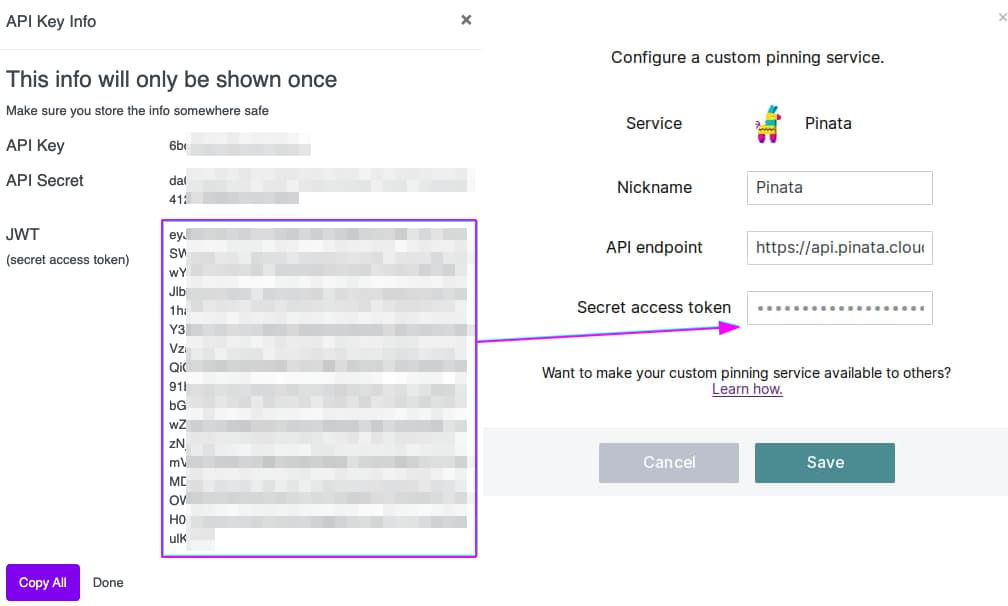

In [ ]:
#| ignoretest
res, content = api.rspin_add('pinata', 'https://api.pinata.cloud/psa', os.environ['pinata_api_secret']);res.status_code

200

Let's list the pinned services to see if we successfully added `pinata`

`Pinata` has been added

In [ ]:
#| ignoretest
response, content = api.rspin_ls(); content

[{'RemoteServices': [{'Service': 'pinata',
    'ApiEndpoint': 'https://api.pinata.cloud/psa'}]}]

## Remote Pinning

In [ ]:
show_doc(IPFSApi.rpin_add)

<h4 id="IPFSApi.rpin_add" class="doc_header"><code>IPFSApi.rpin_add</code><a href="__main__.py#L325" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.rpin_add</code>(**`cid`**:`str`, **`service`**:`str`, **`background`**:`str`=*`'false'`*, **\*\*`kwargs`**)

Pin object to remote pinning service.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||Path to IPFS object(s) to be pinned|
|**`service`**|`str`||Name of the remote pinning service to use|
|**`background`**|`str`|`false`|Add to the queue on the remote service and return immediately (does not wait for pinned status)|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.rpin_ls)

<h4 id="IPFSApi.rpin_ls" class="doc_header"><code>IPFSApi.rpin_ls</code><a href="__main__.py#L348" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.rpin_ls</code>(**`service`**:`str`, **\*\*`kwargs`**)

List objects pinned to remote pinning service.

||Type|Default|Details|
|---|---|---|---|
|**`service`**|`str`||Name of the remote pinning service to use|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.rpin_rm)

<h4 id="IPFSApi.rpin_rm" class="doc_header"><code>IPFSApi.rpin_rm</code><a href="__main__.py#L366" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.rpin_rm</code>(**`service`**:`str`, **\*\*`kwargs`**)

Remove pins from remote pinning service.

||Type|Default|Details|
|---|---|---|---|
|**`service`**|`str`||Name of the remote pinning service to use|
|**`kwargs`**|||*No Content*|


Let's add a new file to IPFS and pin it to `pinata`. 

In [ ]:
#| ignoretest
response, content = api.add_items(filepath='output/test.txt'); content

[{'Name': 'test.txt', 'Bytes': 24},
 {'Name': 'test.txt',
  'Hash': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
  'Size': '32'}]

In [ ]:
#| ignoretest
response, content = api.rpin_add('QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb', 'pinata'); response.status_code

HTTPError: Response Status Code: 500; Error Message: reason: "DUPLICATE_OBJECT", details: "Object already pinned to pinata. Please remove or replace existing pin object.": 400 Bad Request

As can ber seen, we have successfully added the file to `pinata`

In [ ]:
#| ignoretest
response, content = api.rpin_ls('pinata'); content

[{'Status': 'pinned',
  'Cid': 'QmUfwG4P6EA5xbD3De5bS7XKcBion8ReQj7m9ZjxaPvq3B',
  'Name': ''},
 {'Status': 'pinned',
  'Cid': 'QmUNLLsPACCz1vLxQVkXqqLX5R1X345qqfHbsf67hvA3Nn',
  'Name': 'policy/12D3KooWPuYpxNLqniaG7pxknEfRLxxYFUXULKXi3bE5zbCFDdCZ/mfs'},
 {'Status': 'pinned',
  'Cid': 'Qmb6W6nVPYd5CJKFpC1zGGuoD7TYQLE5PGG1RHkHm2W3m9',
  'Name': ''},
 {'Status': 'pinned',
  'Cid': 'QmeGotBL5dsmgryJLn2q3krUCjX6F8sBMBBEC6ayknHVYZ',
  'Name': ''},
 {'Status': 'pinned',
  'Cid': 'QmTT8vwdbnP9Ls8bSY1LMyW4a8bEwTYZa5izEoJMBtTPfb',
  'Name': ''}]

## Block

In [ ]:
show_doc(IPFSApi.block_get)

<h4 id="IPFSApi.block_get" class="doc_header"><code>IPFSApi.block_get</code><a href="__main__.py#L384" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.block_get</code>(**`cid`**:`str`)

Get a raw IPFS block.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||The base58 multihash of an existing block to get|


In [ ]:
show_doc(IPFSApi.block_put)

<h4 id="IPFSApi.block_put" class="doc_header"><code>IPFSApi.block_put</code><a href="__main__.py#L401" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.block_put</code>(**`filepath`**:`str`, **`mhtype`**:`str`=*`'sha2-256'`*, **`mhlen`**:`int`=*`-1`*, **`pin`**:`str`=*`False`*, **\*\*`kwargs`**)

Store input as an IPFS block.

||Type|Default|Details|
|---|---|---|---|
|**`filepath`**|`str`||Path to file|
|**`mhtype`**|`str`|`sha2-256`|multihash hash function.|
|**`mhlen`**|`int`|`-1`|Multihash hash length|
|**`pin`**|`str`|`False`|pin added blocks recursively|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.block_rm)

<h4 id="IPFSApi.block_rm" class="doc_header"><code>IPFSApi.block_rm</code><a href="__main__.py#L424" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.block_rm</code>(**`cid`**:`str`, **`force`**:`str`=*`'false'`*, **`quiet`**:`str`=*`'false'`*)

Remove IPFS block(s).

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||Bash58 encoded multihash of block(s) to remove|
|**`force`**|`str`|`false`|Ignore nonexistent blocks.|
|**`quiet`**|`str`|`false`|Write minimal output.|


In [ ]:
show_doc(IPFSApi.block_stat)

<h4 id="IPFSApi.block_stat" class="doc_header"><code>IPFSApi.block_stat</code><a href="__main__.py#L444" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.block_stat</code>(**`cid`**:`str`)

Print information of a raw IPFS block.

||Type|Default|Details|
|---|---|---|---|
|**`cid`**|`str`||Bash58 encoded multihash of block(s) to remove|


### Work with blocks

To explore the `blocks` modeule, let's add a large file

In [ ]:
#| ignoretest
response, content = api.add_items('output/adult_data.csv'); content

[{'Name': 'adult_data.csv', 'Bytes': 262144},
 {'Name': 'adult_data.csv', 'Bytes': 524288},
 {'Name': 'adult_data.csv', 'Bytes': 786432},
 {'Name': 'adult_data.csv', 'Bytes': 1048576},
 {'Name': 'adult_data.csv', 'Bytes': 1310720},
 {'Name': 'adult_data.csv', 'Bytes': 1572864},
 {'Name': 'adult_data.csv', 'Bytes': 1835008},
 {'Name': 'adult_data.csv', 'Bytes': 2097152},
 {'Name': 'adult_data.csv', 'Bytes': 2359296},
 {'Name': 'adult_data.csv', 'Bytes': 2621440},
 {'Name': 'adult_data.csv', 'Bytes': 2883584},
 {'Name': 'adult_data.csv', 'Bytes': 3145728},
 {'Name': 'adult_data.csv', 'Bytes': 3407872},
 {'Name': 'adult_data.csv', 'Bytes': 3670016},
 {'Name': 'adult_data.csv', 'Bytes': 3932160},
 {'Name': 'adult_data.csv', 'Bytes': 3974475},
 {'Name': 'adult_data.csv',
  'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
  'Size': '3975476'}]

As you can see from below, adding it results in `blocks` and we are given the `root CID`

We can take a look at the `CIDs` of different block like below

In [ ]:
#| ignoretest
response, content = api.ls_items('QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V');content

[{'Objects': [{'Hash': 'QmZnxARhJWsCbTxiAzoRhnxHgMtoEkNJNS8DGLCBEMvm4V',
    'Links': [{'Name': '',
      'Hash': 'Qmc7fYo65HLt1bwN6GudwZfq5MrAGYQ2wwsQ9y1fh6zNz9',
      'Size': 262144,
      'Type': 2,
      'Target': ''},
     {'Name': '',
      'Hash': 'QmY1DtAnTrDX3KPgHFMPk6Zapa53s1fCapXChLBN9sMSQ4',
      'Size': 262144,
      'Type': 2,
      'Target': ''},
     {'Name': '',
      'Hash': 'QmY6TEEHe4WiJVAcY6Lo9shWfc8WVQHV6HtBE8HaEfYykV',
      'Size': 262144,
      'Type': 2,
      'Target': ''},
     {'Name': '',
      'Hash': 'QmRw8SE71wXbRYr4pttxJAhHCcxsTLqdimkNEPUkmJoppe',
      'Size': 262144,
      'Type': 2,
      'Target': ''},
     {'Name': '',
      'Hash': 'QmYCUnARWF3jesUjc23Ku2sdxstoNjkzgevPcG95skkzq3',
      'Size': 262144,
      'Type': 2,
      'Target': ''},
     {'Name': '',
      'Hash': 'Qmdc41AcSjYZ9qazoFdeWY9zrEEQv5e3mp2wuTbbMBVgis',
      'Size': 262144,
      'Type': 2,
      'Target': ''},
     {'Name': '',
      'Hash': 'QmUzwuZkN7HMHXa169vZAZDcMu9DGzPUD

In [ ]:
#| ignoretest
blocks = content[0]["Objects"][0]["Links"]

In [ ]:
#| ignoretest
print(f'Number of blocks: {len(blocks)}')

Number of blocks: 16


Here, we can see the three blocks of the total 16 blocks.

In [ ]:
#| ignoretest
blocks[:3]

[{'Name': '',
  'Hash': 'Qmc7fYo65HLt1bwN6GudwZfq5MrAGYQ2wwsQ9y1fh6zNz9',
  'Size': 262144,
  'Type': 2,
  'Target': ''},
 {'Name': '',
  'Hash': 'QmY1DtAnTrDX3KPgHFMPk6Zapa53s1fCapXChLBN9sMSQ4',
  'Size': 262144,
  'Type': 2,
  'Target': ''},
 {'Name': '',
  'Hash': 'QmY6TEEHe4WiJVAcY6Lo9shWfc8WVQHV6HtBE8HaEfYykV',
  'Size': 262144,
  'Type': 2,
  'Target': ''}]

Let's read whats in the first and second block

In [ ]:
#| ignoretest
response, content = api.cat_items(blocks[0]['Hash'])

In [ ]:
#| ignoretest
print(response.text[:100]); len(response.text)

age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, se


262144

In [ ]:
#| ignoretest
response, content = api.cat_items(blocks[1]['Hash'])

In [ ]:
#| ignoretest
print(response.text[:100]); len(response.text)

nited-States, <=50K
28, Private, 201175, 11th, 7, Never-married, Machine-op-inspct, Not-in-family, B


262144

We can also read using the `cat` method under the `blocks` module in which case if block is an intermediate block it will only print the raw binary data.

In [ ]:
#| ignoretest
response, content = api.block_get(blocks[0]['Hash'])

In [ ]:
#| ignoretest
response.text[:300]

'\n\x8a\x80\x10\x08\x02\x12\x80\x80\x10age, workclass, fnlwgt, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, salary\n39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States'

#### Add a block

In [ ]:
#| ignoretest
response, content = api.block_put('../README.md'); content

[{'Key': 'bafkreicb2n4nhac6nwsviqe2ik4pt22ukewf7zfz2j2aof2au3a2qgi3oa',
  'Size': 1179}]

#### Get stat on a block

In [ ]:
#| ignoretest
response, content = api.block_stat('bafkreicb2n4nhac6nwsviqe2ik4pt22ukewf7zfz2j2aof2au3a2qgi3oa'); content

[{'Key': 'bafkreicb2n4nhac6nwsviqe2ik4pt22ukewf7zfz2j2aof2au3a2qgi3oa',
  'Size': 1179}]

#### Remove a block

In [ ]:
#| ignoretest
response, content = api.block_rm('bafkreicb2n4nhac6nwsviqe2ik4pt22ukewf7zfz2j2aof2au3a2qgi3oa'); response.status_code

200

In [ ]:
#| hide
# def ipns_publish(
#     coreurl:str, 
#     ipfspath:str, # IPFS path of the object to be published
#     resolve:str='true', # Check if the given path can be resolved before publishing
#     key:str='self', # Name of the key to be used or a valid PeerID, as listed by `ipfs key list -l`
#     ipns_base:str='base36', # Encoding used for keys: Can either be a multibase encoded CID or a base58btc encoded multihash
#     **kwargs,
# ):
#     'Publish IPNS names.'
    
#     params = {}
#     params['arg'] = ipfspath
#     params['resolve'] = resolve
#     params['key'] = key
#     params['ipns-base'] = ipns_base
#     params.update(kwargs)
    
#     response = requests.post(f'{coreurl}/name/publish', params=params)
    
#     return response, parse_response(response)

# def ipns_view(
#     ipns_hash:str # IPNS address where the files are stored
# ):
#     'View files published to IPNS.'

#     response = requests.get(f'https://gateway.ipfs.io/ipns/{ipns_hash}')
    
#     return response, parse_response(response)

## Mutable File System (files)

In [ ]:
show_doc(IPFSApi.mfs_chcid)

<h4 id="IPFSApi.mfs_chcid" class="doc_header"><code>IPFSApi.mfs_chcid</code><a href="__main__.py#L461" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_chcid</code>(**`path`**:`str`=*`'/'`*, **`cid_version`**:`int`=*`0`*, **\*\*`kwargs`**)

Change the CID version or hash function of the root node of a given path.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|`str`|`/`|Path to change|
|**`cid_version`**|`int`|`0`|Cid version to use|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_cp)

<h4 id="IPFSApi.mfs_cp" class="doc_header"><code>IPFSApi.mfs_cp</code><a href="__main__.py#L481" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_cp</code>(**`source_path`**:`str`, **`dest_path`**:`str`, **\*\*`kwargs`**)

Add references to IPFS files and directories in MFS (or copy within MFS).

||Type|Default|Details|
|---|---|---|---|
|**`source_path`**|`str`||Source IPFS or MFS path to copy|
|**`dest_path`**|`str`||Destination within MFS|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_flush)

<h4 id="IPFSApi.mfs_flush" class="doc_header"><code>IPFSApi.mfs_flush</code><a href="__main__.py#L500" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_flush</code>(**`path`**:`str`=*`'/'`*)

Flush a given path's data to disk

||Type|Default|Details|
|---|---|---|---|
|**`path`**|`str`|`/`|Path to flush|


In [ ]:
show_doc(IPFSApi.mfs_ls)

<h4 id="IPFSApi.mfs_ls" class="doc_header"><code>IPFSApi.mfs_ls</code><a href="__main__.py#L515" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_ls</code>(**`path`**:`str`=*`'/'`*, **\*\*`kwargs`**)

List directories in the local mutable namespace.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|`str`|`/`|Path to show listing for|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_mkdir)

<h4 id="IPFSApi.mfs_mkdir" class="doc_header"><code>IPFSApi.mfs_mkdir</code><a href="__main__.py#L533" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_mkdir</code>(**`path`**:`str`, **\*\*`kwargs`**)

Make directories.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|`str`||Path to dir to make|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_mv)

<h4 id="IPFSApi.mfs_mv" class="doc_header"><code>IPFSApi.mfs_mv</code><a href="__main__.py#L551" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_mv</code>(**`source_path`**:`str`, **`dest_path`**:`str`)

Move files.

||Type|Default|Details|
|---|---|---|---|
|**`source_path`**|`str`||Source file to move|
|**`dest_path`**|`str`||Destination path for file to be moved to|


In [ ]:
show_doc(IPFSApi.mfs_read)

<h4 id="IPFSApi.mfs_read" class="doc_header"><code>IPFSApi.mfs_read</code><a href="__main__.py#L568" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_read</code>(**`path`**, **\*\*`kwargs`**)

Read a file in a given MFS.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|||Path to file to be read|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_rm)

<h4 id="IPFSApi.mfs_rm" class="doc_header"><code>IPFSApi.mfs_rm</code><a href="__main__.py#L586" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_rm</code>(**`path`**, **\*\*`kwargs`**)

Read a file in a given MFS.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|||File to remove|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_stat)

<h4 id="IPFSApi.mfs_stat" class="doc_header"><code>IPFSApi.mfs_stat</code><a href="__main__.py#L604" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_stat</code>(**`path`**, **\*\*`kwargs`**)

Display file status.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|||Path to node to stat|
|**`kwargs`**|||*No Content*|


In [ ]:
show_doc(IPFSApi.mfs_write)

<h4 id="IPFSApi.mfs_write" class="doc_header"><code>IPFSApi.mfs_write</code><a href="__main__.py#L622" class="source_link" style="float:right">[source]</a></h4>

> <code>IPFSApi.mfs_write</code>(**`path`**, **`filepath`**, **`create`**=*`True`*, **\*\*`kwargs`**)

Display file status.

||Type|Default|Details|
|---|---|---|---|
|**`path`**|||Path to write to|
|**`filepath`**|||File to add|
|**`create`**|`bool`|`True`|Create the file if it does not exist|
|**`kwargs`**|||*No Content*|


### Working with MFS

Making a directory

In [ ]:
#| ignoretest
response, content = api.mfs_mkdir('/test'); response.status_code

200

In [ ]:
#|hide
from nbdev.doclinks import *
nbdev_export()

Converted 00_utils.ipynb.
Converted 01_ipfshttpapi.ipynb.
Converted 03_estuaryapi.ipynb.
Converted 04_pinataapi.ipynb.
Converted index.ipynb.
